# Importacao dos bibliotecas

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE, VarianceThreshold
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
import warnings
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.simplefilter(action="ignore", category=FutureWarning)

# Coleta dos dados

In [2]:
teste = pd.read_csv("air_system_present_year.csv")
treino = pd.read_csv("air_system_previous_years.csv")

# Tratando os dados

In [3]:
treino_trat = treino.copy()
test_trat = teste.copy()

In [4]:
# Tratamento dos dados 
## Remover colunas com valores ausentes e 0 maior de 40%
def remove_valores_ausentes_zero(treino, teste, label):
    lista_valores_ausentes_zero = []
    for coluna in treino.columns:
        if coluna == label:
            continue
        else:
            if (treino[coluna].isnull().sum() + sum(treino[coluna] == 0)) / len(
                treino
            ) >= 0.4:
                lista_valores_ausentes_zero.append(coluna)
    treino.drop(columns=lista_valores_ausentes_zero, inplace=True)
    teste.drop(columns=lista_valores_ausentes_zero, inplace=True)
    ## Selecionar linhas com pelo menos 50 colunas preenchidas
    treino = treino[treino.notnull().sum(axis=1) >= 50]
    teste = teste[teste.notnull().sum(axis=1) >= 50]
    return treino, teste


def colunas_numericas(treino, teste, label):
    for coluna in treino.columns:
        if coluna == label:
            continue
        else:
            treino[coluna] = pd.to_numeric(treino[coluna], errors="coerce")
            teste[coluna] = pd.to_numeric(teste[coluna], errors="coerce")
    return treino, teste

In [5]:
treino_trat = treino.copy()
test_trat = teste.copy()
##Transformar colunas em numéricas
treino_trat, test_trat = colunas_numericas(treino_trat, test_trat, "class")
## Remover colunas com valores ausentes e 0 maior de 40% e Selecionar linhas com pelo menos 50 colunas preenchidas
treino_trat, test_trat = remove_valores_ausentes_zero(treino_trat, test_trat, "class")
##Transfomando as classes em numericas
treino_trat["class"] = np.where(treino_trat["class"] == "pos", 1, 0)
test_trat["class"] = np.where(test_trat["class"] == "pos", 1, 0)

## Divisao e y e x
y_treino = treino_trat["class"]
x_treino = treino_trat.drop(columns="class")
y_teste = test_trat["class"]
x_teste = test_trat.drop(columns="class")

print("Shape do x_treino:", x_treino.shape)
print("Shape do y_treino:", y_treino.shape)
print("Shape do x_teste:", x_teste.shape)
print("Shape do y_teste:", y_teste.shape)

Shape do x_treino: (59606, 99)
Shape do y_treino: (59606,)
Shape do x_teste: (15891, 99)
Shape do y_teste: (15891,)


In [10]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("resampled", RandomOverSampler(sampling_strategy=1)),
        ("scaler", StandardScaler()),
        ("variance", VarianceThreshold(threshold=0.3)),
        (
            "correlacao",
            SmartCorrelatedSelection(selection_method="variance", threshold=0.7),
        ),
        ("rfe", RFE(estimator=RandomForestClassifier(), n_features_to_select=20)),
        ("clf", RandomForestClassifier()),
    ]
)

In [11]:
pipe.fit(x_treino, y_treino)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('resampled', RandomOverSampler(sampling_strategy=1)),
                ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0.3)),
                ('correlacao',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7)),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=20)),
                ('clf', RandomForestClassifier())])

In [15]:
y_pred = pipe.predict(x_teste)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_teste, y_pred)

0.9894279781008117

Text(0.5, 1.0, 'Matriz de confusao')

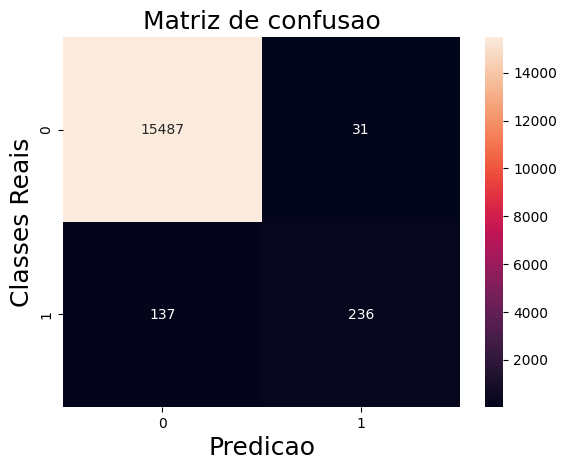

In [23]:
sns.heatmap(confusion_matrix(y_teste, y_pred),annot=True,fmt='g')
plt.xlabel('Predicao',fontsize=18)
plt.ylabel('Classes Reais',fontsize=18);
plt.title('Matriz de confusao',fontsize=18)

In [21]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.88      0.63      0.74       373

    accuracy                           0.99     15891
   macro avg       0.94      0.82      0.87     15891
weighted avg       0.99      0.99      0.99     15891



In [25]:
pipe.predict_proba(x_teste)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])